# 2024-1 DSL 정규세션 과제

## CNN Assignment

- 작성자 : 윤형진
- 참고자료 : PyTorch Document
- 과제 제출 기한 : 02.18

---
- 이름 :    김지원
- 기수 :     11기



In [2]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.9/257.9 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00


In [3]:
# colab 환경에서 학습을 진행하실 분들은 구글드라이브를 연동해주세요
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd /content/drive/MyDrive/03)DSL/0_정기세미나/기초과제/기초과제4/[240206]_CNN_JiwonKim/scripts

/content/drive/MyDrive/03)DSL/0_정기세미나/기초과제/기초과제4/[240206]_CNN_JiwonKim/scripts


In [5]:
# 이번 과제의 일부였던 CustomDataset.py, Model.py를 로드해주세요
from CustomDataset import CustomImageDataset
from Model import ResNet50

import pandas as pd
import numpy as np

import yaml
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F

from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [6]:
# config.yaml의 위치를 지정해주세요
config_path = "/content/drive/MyDrive/03)DSL/0_정기세미나/기초과제/기초과제4/[240206]_CNN_JiwonKim/scripts/config.yaml"

# 1. 하이퍼파라미터 및 기타 주요 변수 설정

config.yaml에 지정해줬던 디렉토리, 모델 하이퍼파라미터들을 가져옵시다

In [7]:
# config.yaml에서 디렉토리, 모델 하이퍼파라미터를 각각 받아옵니다
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

dataset_direc, meta_direc, weight_direc \
    = config["Direc"]["DatasetDirec"], \
      config["Direc"]["MetaDataDirec"], \
      config["Direc"]["WeightDirec"]

epoch, batch_size, lr \
    = config["HyperParameters"]["Epoch"], \
      config["HyperParameters"]["BatchSize"], \
      float(config["HyperParameters"]["LearningRate"]) # config.yaml에서 이미 float 자료형으로 학습률을 정의하신 분은 float()으로 자료형 변환을 하지 않으셔도 됩니다.



In [8]:
print(epoch, batch_size, lr)

40 80 0.001


In [9]:
import wandb # wandb.ai으로의 실시간 연동을 위한 라이브러리 임포트
from signal import signal, SIGPIPE, SIG_DFL
#Ignore SIG_PIPE and don't throw exceptions on it... (http://docs.python.org/library/signal.html)
signal(SIGPIPE,SIG_DFL)

# wandb login
wandb.init(
    project="DSL_ResNet", entity="jwkim808",
    name='no_agument',
    config={
        "model_name": 'ResNet', # augmentation을 적용한 것과 다른 이름을 주도록 하세요 :)
        "epochs": epoch, #<config.yaml에서 가져온 에포크>
        "batch_size":batch_size,#<config.yaml에서 가져온 batch size>
        "lr": lr #<config.yaml에서 가져온 학습률>
    })

config = wandb.config

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [10]:
# 가속을 위해 device로 GPU로 설정해줍니다
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# 2. train, val, test DataLoader 초기화

In [11]:
# MetaData.csv를 로드해주고, train, val, test로 나눠줍니다
meta_data = pd.read_csv('/content/drive/MyDrive/03)DSL/0_정기세미나/기초과제/기초과제4/[240206]_CNN_JiwonKim/scripts/MetaData.csv')

# train : val : test = 6 : 2 : 2
train, val_temp = train_test_split(meta_data, train_size=0.6, random_state=777)
val, test = train_test_split(val_temp, train_size=0.5, random_state=777)

# CustomDataset.py에서 가져온 CustomImageDataset 클래스에 train, val, test 데이터프레임을 패스하여 데이터셋을 만들어주세요
train_dataset = CustomImageDataset(dataset_direc=dataset_direc, df=train)
val_dataset   = CustomImageDataset(dataset_direc=dataset_direc, df=val)
test_dataset  = CustomImageDataset(dataset_direc=dataset_direc, df=test)


train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)


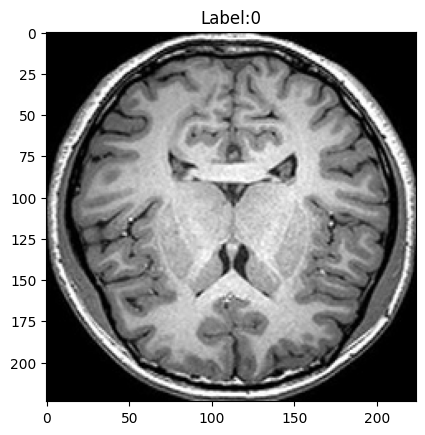

In [12]:
import matplotlib.pyplot as plt

#데이터셋에서 첫 번째 이미지와 레이블 가져오기
img, label = train_dataset[1]

#img가 PIL이미지가 아닌 텐서 형태일 경우, 시각화를 위해 PIL, Image로 변환
if isinstance(img, torch.Tensor):
  img = transforms.ToPILImage()(img)

#이미지 시각화
plt.imshow(img, cmap ='gray')
plt.title(f"Label:{label}")
plt.show()

# 3. 모델 초기화, 손실함수 및 optimizer 지정

In [13]:
# model을 선언하고 GPU에 올려줍니다
model = ResNet50()
model.to(device)

ResNet50(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResBottleNeck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (residual): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(

In [14]:
# 손실함수를 정의해주세요
criterion = nn.BCEWithLogitsLoss()
# optimizer를 정의해주세요
optimizer = optim.Adam(model.parameters(), lr=lr)

# 4. Training 시작

학습을 위한 모든 준비가 끝났습니다! ㄱㅂㅈㄱ

In [15]:
# Best Validation Loss를 양의 무한대로 초기화
best_loss = float("inf")

# Training, Validation 시작
for curr_epoch in range(epoch + 1):  # iterate over all EPOCHS
    train_loss = 0
    correct_train = 0
    total_train = 0  # 총 학습 데이터 수를 계산하기 위한 변수
    print("")
    model.train()  # 모델을 학습 모드로 설정
    for img, label in train_loader:  # iterate over all BATCHES
        img, label = img.to(device), label.to(device)  # GPU에 데이터 올리기
        pred = model(img)  # Forward Propagation

        label = label.view(-1, 1).float()  # 목표 텐서의 모양 조정
        loss = criterion(pred, label)  # 손실함수 계산

        optimizer.zero_grad()  # 누적된 기울기 초기화
        loss.backward()  # 역전파
        optimizer.step()  # 파라미터 업데이트

        train_loss += loss.item()  # 해당 Batch에서의 loss 누적

        pred_class = (torch.sigmoid(pred) > 0.5).float()  # 이진 분류를 위한 임계값 적용
        correct_train += (pred_class == label).float().sum()  # 정확도 계산
        total_train += label.size(0)

    train_loss /= len(train_loader)  # 평균 학습 손실
    train_acc = correct_train / total_train  # 평균 학습 정확도

    # Validation 시작
    model.eval()  # 모델을 평가 모드로 설정
    val_loss = 0
    correct_val = 0
    total_val = 0  # 총 검증 데이터 수를 계산하기 위한 변수
    with torch.no_grad():  # 기울기 계산을 하지 않음
        for img, label in val_loader:
            img, label = img.to(device), label.to(device)
            pred = model(img)
            label = label.view(-1, 1).float()

            loss = criterion(pred, label)  # 손실함수 계산
            val_loss += loss.item()  # 해당 Batch에서의 loss 누적

            pred_class = (torch.sigmoid(pred) > 0.5).float()  # 이진 분류를 위한 임계값 적용
            correct_val += (pred_class == label).float().sum()  # 정확도 계산
            total_val += label.size(0)

    val_loss /= len(val_loader)  # 평균 검증 손실
    val_acc = correct_val / total_val  # 평균 검증 정확도

    print(f"Epoch {curr_epoch}/{epoch}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    metrics = {
        "epoch": curr_epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_acc": train_acc.item(),
        "val_acc": val_acc.item(),
        "learning_rate": lr
    }

    wandb.log(metrics)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), os.path.join(weight_direc, "best_model(aug).pt"))

wandb.finish()


Epoch 0/40, Train Loss: 0.8457, Train Acc: 0.6011, Val Loss: 0.7034, Val Acc: 0.5467

Epoch 1/40, Train Loss: 0.5250, Train Acc: 0.7478, Val Loss: 3.9785, Val Acc: 0.5500

Epoch 2/40, Train Loss: 0.5223, Train Acc: 0.7328, Val Loss: 0.6402, Val Acc: 0.6817

Epoch 3/40, Train Loss: 0.4816, Train Acc: 0.7894, Val Loss: 3.7904, Val Acc: 0.5450

Epoch 4/40, Train Loss: 0.4465, Train Acc: 0.7917, Val Loss: 0.8380, Val Acc: 0.7317

Epoch 5/40, Train Loss: 0.4009, Train Acc: 0.8156, Val Loss: 0.6750, Val Acc: 0.7433

Epoch 6/40, Train Loss: 0.3999, Train Acc: 0.8206, Val Loss: 0.7883, Val Acc: 0.7117

Epoch 7/40, Train Loss: 0.3673, Train Acc: 0.8344, Val Loss: 1.5166, Val Acc: 0.6467

Epoch 8/40, Train Loss: 0.3453, Train Acc: 0.8533, Val Loss: 1.1995, Val Acc: 0.5867

Epoch 9/40, Train Loss: 0.2619, Train Acc: 0.8856, Val Loss: 2.4156, Val Acc: 0.5750

Epoch 10/40, Train Loss: 0.2709, Train Acc: 0.8894, Val Loss: 0.3672, Val Acc: 0.8800

Epoch 11/40, Train Loss: 0.2272, Train Acc: 0.9111, 